<a href="https://colab.research.google.com/github/VelizarZ/GIP_2025/blob/main/Frequency_sweep_post_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Oscillation starts at ~363.943 s.
Displacement appears to stop moving (within ±0.5 mm) at ~568.775 s.


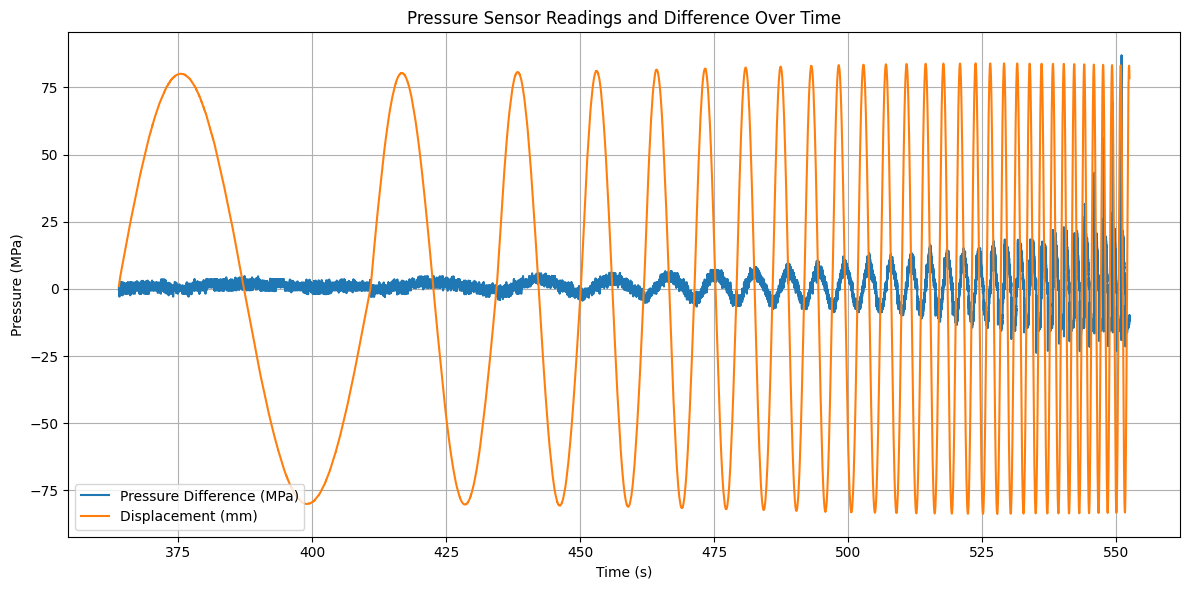

Wave 1: Start Time = 363.943 s, Max Speed = 0.011 mm/s
Wave 2: Start Time = 410.860 s, Max Speed = 0.021 mm/s
Wave 3: Start Time = 434.409 s, Max Speed = 0.032 mm/s
Wave 4: Start Time = 450.125 s, Max Speed = 0.043 mm/s
Wave 5: Start Time = 461.912 s, Max Speed = 0.053 mm/s
Wave 6: Start Time = 471.342 s, Max Speed = 0.064 mm/s
Wave 7: Start Time = 479.201 s, Max Speed = 0.075 mm/s
Wave 8: Start Time = 485.938 s, Max Speed = 0.085 mm/s
Wave 9: Start Time = 491.833 s, Max Speed = 0.096 mm/s
Wave 10: Start Time = 497.073 s, Max Speed = 0.107 mm/s
Wave 11: Start Time = 501.788 s, Max Speed = 0.117 mm/s
Wave 12: Start Time = 506.075 s, Max Speed = 0.128 mm/s
Wave 13: Start Time = 510.004 s, Max Speed = 0.139 mm/s
Wave 14: Start Time = 513.631 s, Max Speed = 0.149 mm/s
Wave 15: Start Time = 516.999 s, Max Speed = 0.160 mm/s
Wave 16: Start Time = 520.142 s, Max Speed = 0.171 mm/s
Wave 17: Start Time = 523.089 s, Max Speed = 0.181 mm/s
Wave 18: Start Time = 525.862 s, Max Speed = 0.192 mm/s
W

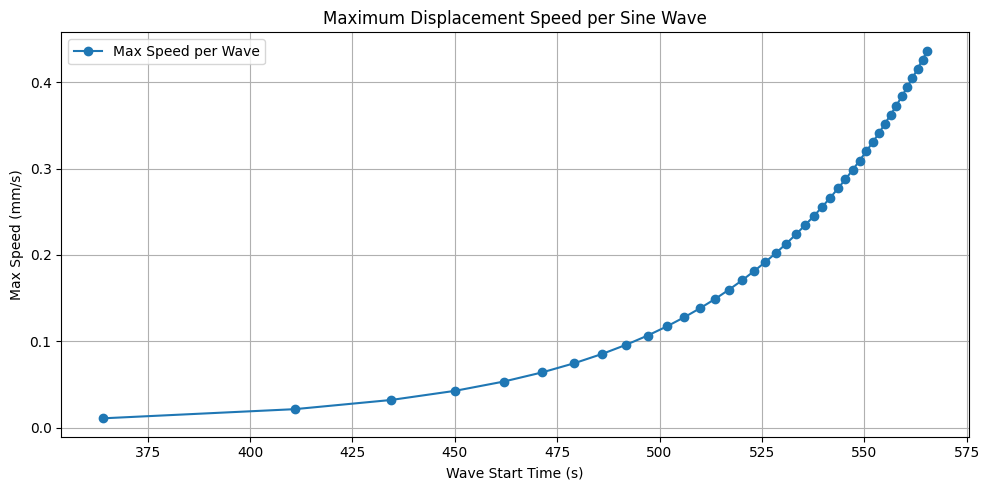

Wave 1: Start Time = 363.943 s, Max Pressure Difference = 4.800 MPa
Wave 2: Start Time = 410.860 s, Max Pressure Difference = 4.800 MPa
Wave 3: Start Time = 434.409 s, Max Pressure Difference = 5.800 MPa
Wave 4: Start Time = 450.125 s, Max Pressure Difference = 6.100 MPa
Wave 5: Start Time = 461.912 s, Max Pressure Difference = 6.700 MPa
Wave 6: Start Time = 471.342 s, Max Pressure Difference = 7.100 MPa
Wave 7: Start Time = 479.201 s, Max Pressure Difference = 8.200 MPa
Wave 8: Start Time = 485.938 s, Max Pressure Difference = 9.900 MPa
Wave 9: Start Time = 491.833 s, Max Pressure Difference = 10.500 MPa
Wave 10: Start Time = 497.073 s, Max Pressure Difference = 12.100 MPa
Wave 11: Start Time = 501.788 s, Max Pressure Difference = 13.400 MPa
Wave 12: Start Time = 506.075 s, Max Pressure Difference = 13.000 MPa
Wave 13: Start Time = 510.004 s, Max Pressure Difference = 13.200 MPa
Wave 14: Start Time = 513.631 s, Max Pressure Difference = 16.500 MPa
Wave 15: Start Time = 516.999 s, Max 

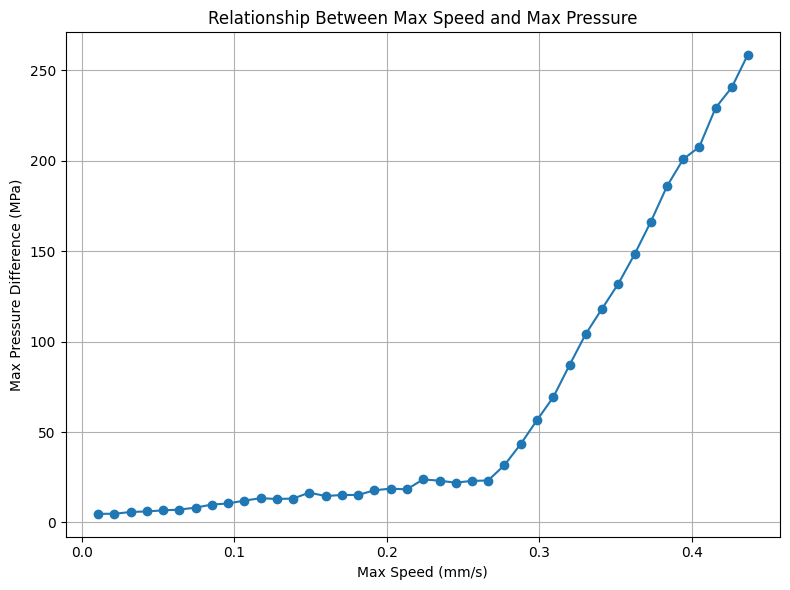

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


amplitude = 0.08

# Define a placeholder calibration function
def millivolts_to_mpa(mv):
    # Replace this with your actual calibration logic
    return mv  # Placeholder: identity function

# Load the CSV file
file_path = '/content/Displacement valve freq sweep 1.csv'
df = pd.read_csv(file_path,skiprows=6)

# Extract relevant columns
id = df["ID"]
time = df["SecondsElapsed"]
sensor1_mv = df["[3]  Millivolts"]
sensor2_mv = df["[4]  Millivolts"]
displacement = df["[2]  mm"]

# Convert millivolts to MPa
sensor1_mpa = sensor1_mv.apply(millivolts_to_mpa)
sensor2_mpa = sensor2_mv.apply(millivolts_to_mpa)

# Calculate pressure difference
pressure_diff = sensor1_mpa - sensor2_mpa


# Convert displacement to numpy array for faster processing
displacement_array = displacement.to_numpy()
time_array = time.to_numpy()

# Step 1: Compute displacement threshold to detect true oscillation start and end
threshold = 1  # mm, adjust based on your noise floor
oscillation_start_idx = np.argmax(np.abs(displacement_array) > threshold)
print(f"Oscillation starts at ~{time_array[oscillation_start_idx]:.3f} s.")

# Step 2: Truncate arrays to start after true oscillation begins
displacement_array = displacement_array[oscillation_start_idx:]
time_array = time_array[oscillation_start_idx:]

# Parameters for detecting stop
stop_threshold = 1.0  # mm
window_size = 50  # number of samples for checking "stopped" condition
stopped_idx = None

# Loop through the signal after oscillation starts
for i in range(len(displacement_array) - window_size):
    window = displacement_array[i:i + window_size]
    if np.max(window) - np.min(window) < stop_threshold:
        # Check if the rest of the signal stays within this threshold
        remaining_disp = displacement_array[i:]
        if np.max(remaining_disp) - np.min(remaining_disp) < stop_threshold:
            stopped_idx = i
            break
# Report result
if stopped_idx is not None:
    stop_time = time_array[stopped_idx]
    print(f"Displacement appears to stop moving (within ±{stop_threshold/2} mm) at ~{stop_time:.3f} s.")
else:
    print("Displacement did not stop moving within the specified window.")



# Step 3: Find zero crossings with displacement threshold
raw_zero_crossings = np.where(np.diff(np.sign(displacement_array)))[0]

# Minimum peak-to-peak displacement required to accept a zero-crossing
min_displacement = 5  # mm, adjust as needed

filtered_zero_crossings = []

# Loop through zero-crossings and apply amplitude threshold
for i in range(len(raw_zero_crossings) - 1):
    idx_start = raw_zero_crossings[i]
    idx_end = raw_zero_crossings[i + 1]
    peak_disp = np.max(np.abs(displacement_array[idx_start:idx_end]))

    if peak_disp >= min_displacement:
        filtered_zero_crossings.append(idx_start)

# Add first index to maintain alignment
filtered_zero_crossings = np.insert(filtered_zero_crossings, 0, 0)
zero_crossings = np.array(filtered_zero_crossings)


# Step 4: Calculate speed (displacement derivative)
speed = np.gradient(displacement_array, time_array)

# Step 5: Pair zero crossings and find max speed in each full wave
max_speeds = []
wave_start_times = []


# We take zero crossings in pairs (every 2 crossings ~ full sine wave)
for i in range(0, len(zero_crossings) - 2, 2):
    idx_start = zero_crossings[i]
    idx_end = zero_crossings[i + 2]

    time_period = time_array[idx_end] - time_array[idx_start]
    max_speed = 2 * np.pi * amplitude / time_period

    max_speeds.append(max_speed)
    wave_start_times.append(time_array[idx_start])

# Plotting
plt.figure(figsize=(12, 6))
# plt.plot(time, sensor1_mpa, label='Sensor 1 (MPa)')
# plt.plot(time, sensor2_mpa, label='Sensor 2 (MPa)')
plt.plot(time[oscillation_start_idx:stopped_idx], pressure_diff[oscillation_start_idx:stopped_idx], label='Pressure Difference (MPa)')
plt.plot(time[oscillation_start_idx:stopped_idx], displacement[oscillation_start_idx:stopped_idx], label='Displacement (mm)')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (MPa)')
plt.title('Pressure Sensor Readings and Difference Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Print results
for i, (t, s) in enumerate(zip(wave_start_times, max_speeds)):
    print(f"Wave {i+1}: Start Time = {t:.3f} s, Max Speed = {s:.3f} mm/s")

plt.figure(figsize=(10, 5))
plt.plot(wave_start_times, max_speeds, marker='o', linestyle='-', label='Max Speed per Wave')
plt.xlabel('Wave Start Time (s)')
plt.ylabel('Max Speed (mm/s)')
plt.title('Maximum Displacement Speed per Sine Wave')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Convert pressure difference to numpy array and align it with the truncated signal
pressure_diff_array = pressure_diff.to_numpy()[oscillation_start_idx:]

# List to store max pressure differences per wave
max_pressure_diffs = []

# Iterate through each wave segment
for i in range(0, len(zero_crossings) - 2, 2):
    idx_start = zero_crossings[i]
    idx_end = zero_crossings[i + 2]
    max_pressure = np.max(np.abs(pressure_diff_array[idx_start:idx_end]))
    max_pressure_diffs.append(max_pressure)

# Optional: Print results
for i, (t, p) in enumerate(zip(wave_start_times, max_pressure_diffs)):
    print(f"Wave {i+1}: Start Time = {t:.3f} s, Max Pressure Difference = {p:.3f} MPa")

plt.figure(figsize=(8, 6))
plt.plot(max_speeds, max_pressure_diffs, marker='o', linestyle='-')
plt.xlabel('Max Speed (mm/s)')
plt.ylabel('Max Pressure Difference (MPa)')
plt.title('Relationship Between Max Speed and Max Pressure')
plt.grid(True)
plt.tight_layout()
plt.show()